In [ ]:
%load_ext autoreload
%autoreload 2

# Explore preprocessed features

## Installation and import of the needed libraries


In [ ]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently running in a Colab environment


### Installation (mandatory on Colab)

First of all we clone the Github repository in order to have all the needed files to perform our analysis.

This is needed only if the current notebook isn't executed directly from the repository folder (e.g. Google Colab)


In [ ]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

Cloning into 'my_repo'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 290 (delta 1), reused 7 (delta 1), pack-reused 280
Receiving objects: 100% (290/290), 13.05 MiB | 8.93 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/my_repo
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 6.2 MB/s eta 0:00:00


### Import and configuration setup


In [ ]:
# python modules
import configparser
import math
import os
import re

# 3rd party modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, StandardScaler, OrdinalEncoder, RobustScaler, Normalizer
from sklearn.pipeline import make_pipeline

# user modules
from utils import util_data, util_preprocess, util_plot, util_models

kaggle.json not found, you cannot use kaggle module.


In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

A numpy Random Generator object is constructed for controlling randomness: necessary for robust results in estimator performance with cross-validation.


In [ ]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

Moreover we import the configuration file to have all the parameters along the notebook.


In [ ]:
# pd.set_option("max_colwidth", 800)

In [ ]:
df = pd.read_csv("data/processed/gsm.csv", sep=",")
df.head()

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
0,599.00,2019.0,6.30,1,0,1,0,1,1,4G,...,1,1,1440.0,3040.0,64.0,6.0,12.2,2.0,8.0,2.0
1,524.52,2019.0,5.70,1,0,1,0,1,1,4G,...,1,1,1080.0,2280.0,64.0,6.0,12.2,2.0,8.0,2.0
2,329.00,2019.0,6.00,1,0,1,1,1,1,4G,...,0,0,1080.0,2160.0,64.0,4.0,12.2,1.0,8.0,1.0
3,304.00,2019.0,5.60,1,0,1,1,1,1,4G,...,0,0,1080.0,2220.0,64.0,4.0,12.2,1.0,8.0,1.0
4,110.00,2020.0,5.71,0,1,0,1,0,0,4G,...,0,0,720.0,1520.0,64.0,3.0,13.0,1.0,5.0,1.0


In [ ]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of nan values: {df.isna().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of rows: 2199
Number of nan values: 0
Number of duplicated rows: 0


## Explore the dataset

### Split in train-test set

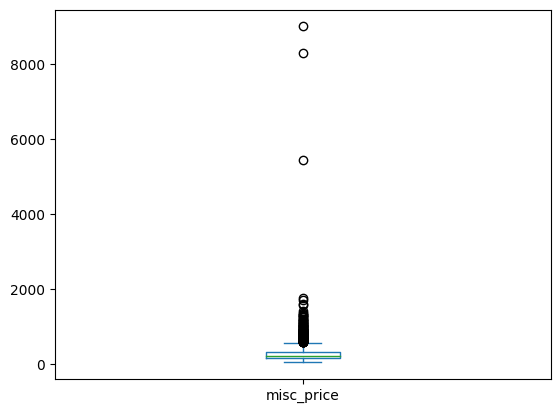

In [ ]:
df.misc_price.plot.box()
plt.show()

Bin 0: 100.00 - 122.33
Bin 1: 122.33 - 156.84
Bin 2: 156.84 - 196.84
Bin 3: 196.84 - 251.49
Bin 4: 251.49 - 313.39
Bin 5: 313.39 - 380.83
Bin 6: 380.83 - 470.80
Bin 7: 470.80 - 610.68
Bin 8: 610.68 - 822.94
Bin 9: 822.94 - 1000.00


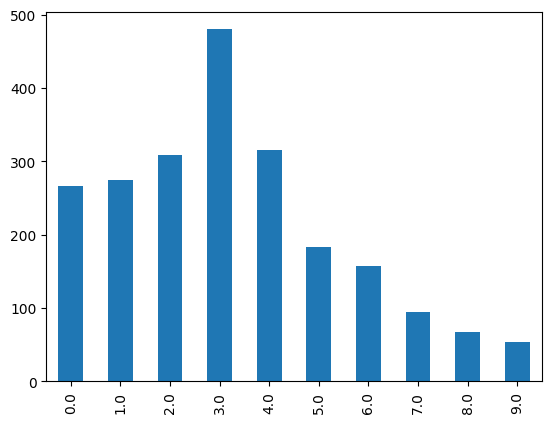

In [ ]:
clip_fun = FunctionTransformer(np.clip, validate=False, check_inverse=False, kw_args={"a_min": 100, "a_max": 1000})
log_fun = FunctionTransformer(np.log, validate=False, check_inverse=True, inverse_func=np.exp)
label_enc = KBinsDiscretizer(n_bins=10, encode="ordinal", subsample=None, strategy="kmeans")

misc_price = df["misc_price"].copy()

label_pipeline = make_pipeline(clip_fun, log_fun, label_enc)
label_cat = label_pipeline.fit_transform(misc_price.values.reshape(-1, 1))

# convert bin edges without the logarithm
bin_edges = np.exp(label_pipeline[2].bin_edges_[0])
for i, (bu, bl) in enumerate(zip(bin_edges, bin_edges[1:])):
    print(f"Bin {i}: {bu:.2f} - {bl:.2f}")

# plot the frequency of each bin
pd.Series(label_cat.flatten()).value_counts().sort_index().plot.bar()
plt.show()

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=rng, shuffle=True, stratify=label_cat)

In [ ]:
print(f"Number of rows in train set: {df_train.shape[0]}")
print(f"Number of rows in test set: {df_test.shape[0]}")

Number of rows in train set: 1759
Number of rows in test set: 440


In [ ]:
# save train and test sets
df_train.to_csv("data/processed/gsm_train.csv", index=False)
df_test.to_csv("data/processed/gsm_test.csv", index=False)

#### Launch announced

Except for the years 2011, 2012, 2013 and 2020, the dataset is balanced for the years. The year 2020 is not balanced because the dataset is not complete for this year, while in the first years the devices were not so many for the features considered (e.g. the resolution of the display was smaller than 1000 pixels).


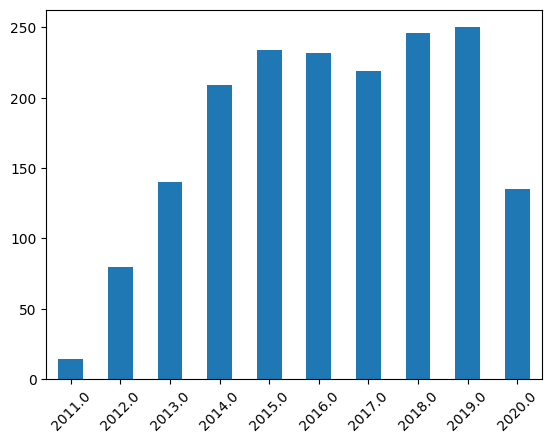

In [ ]:
year_counts = df_train.launch_announced.value_counts().sort_index()

year_counts.plot(kind="bar", rot=45)
plt.show()

#### Misc price

There are many outliers which depicts the presence of some expensive devices. These devices are not removed because even this kind of devices are relevant for the task.

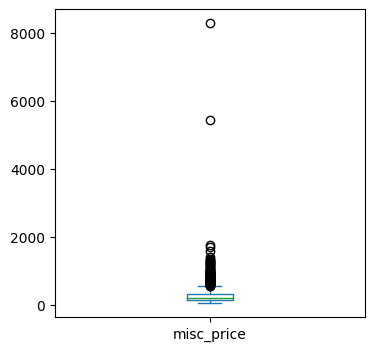

In [ ]:
df_train.misc_price.plot.box(whis=1.5, figsize=(4,4))
plt.show()

In [ ]:
q1, q3 = df_train.misc_price.quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = max(q1 - 1.5 * iqr, df_train.misc_price.min())
upper_bound = min(q3 + 1.5 * iqr, df_train.misc_price.max())
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

print(f"Number of outliers: {df_train.misc_price[df_train.misc_price > upper_bound].shape[0]}")

Lower bound: 40.0
Upper bound: 566.40875
Number of outliers: 118


An approach is to consider the features of these outliers and to see how much they are similar.

In [ ]:
outliers = df_train[df_train.misc_price > upper_bound]
assert isinstance(outliers, pd.DataFrame)
outliers.head()

,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,network_technology,...,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
350,1000.000000,2019.0,6.59,1,0,1,1,1,1,4G,...,0,0,1080.0,2340.0,128.0,8.0,48.0,2.0,24.0,1.0
11,635.566862,2020.0,6.57,1,0,1,0,1,1,5G,...,0,1,1080.0,2340.0,128.0,8.0,40.0,4.0,32.0,2.0
348,1000.000000,2019.0,5.80,1,0,1,0,1,1,4G,...,1,1,1125.0,2436.0,64.0,4.0,12.0,3.0,12.0,2.0
720,570.000000,2018.0,6.40,0,0,0,1,1,1,4G,...,0,0,1080.0,2310.0,256.0,8.0,48.0,2.0,25.0,1.0
2060,805.000000,2016.0,5.70,1,1,0,1,1,1,4G,...,1,1,1440.0,2560.0,64.0,4.0,12.0,1.0,5.0,1.0


q1: 150.00, q3: 310.00

lower_bound: 60.53, upper_bound: 700.00

Range low: 63.08 - 154.23

Range low-medium: 154.23 - 220.00

Range medium: 220.00 - 310.00

Range high: 310.00 - 700.00

Range low: 40.00 - 154.23

Range low-medium: 154.23 - 220.00

Range medium: 220.00 - 310.00

Range high: 310.00 - 700.00



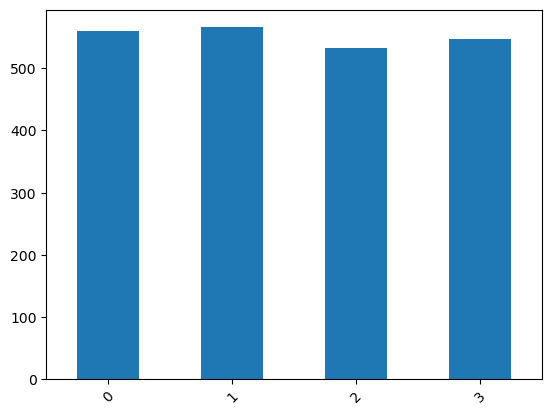

In [ ]:
def get_bins(df:pd.DataFrame, label: str, log=True, cap=False, cap_value=None, verbose=False) -> pd.Series:
    vvprint = lambda x: print(x, end="\n\n") if verbose else lambda *a, **k: None
    if cap:
        assert cap_value is not None

    label_series = df[label].clip(lower=cap_value["low"], upper=cap_value["up"]).copy() if cap else df[label].copy()
    label_series = np.log(label_series) if log else label_series

    q1 = label_series.quantile(0.25)
    q3 = label_series.quantile(0.75)
    vvprint(f"q1: {np.exp(q1) if log else q1:.2f}, q3: {np.exp(q3) if log else q3:.2f}")
    # Take inter-quartile range
    iqr = q3 - q1
    # lower whiskers as 1.5 smaller than iqr
    lower_bound = max(label_series.min(), q1 - iqr * 1.25)
    # upper whiskers as 1.5 greater than iqr
    upper_bound = min(label_series.max(), q3 + iqr * 1.25)

    vvprint(f"lower_bound: {np.exp(lower_bound) if log else lower_bound:.2f}, upper_bound: {np.exp(upper_bound) if log else upper_bound:.2f}")

    # dataframe with outliers removed
    label_iqr = label_series[label_series.between(lower_bound, upper_bound, inclusive="both")]
    # label of the bins
    target_labels = ["low", "low-medium", "medium", "high"]
    # _, bins = pd.cut(label_iqr, bins=len(target_labels), retbins=True, labels=target_labels)
    _, bins = pd.qcut(label_iqr, q=4, retbins=True, labels=target_labels, duplicates="raise")

    for i, (l, u) in enumerate(zip(bins[:-1], bins[1:])):
        vvprint(f"Range {target_labels[i]}: {np.exp(l) if log else l:.2f} - {np.exp(u) if log else u:.2f}")

    bins[0] = label_series.min()
    bins[-1] = label_series.max()
    lab_cat = pd.Series(index=label_series.index, dtype="object")

    for i, (l, u) in enumerate(zip(bins[:-1], bins[1:])):
        vvprint(f"Range {target_labels[i]}: {np.exp(l) if log else l:.2f} - {np.exp(u) if log else u:.2f}")
        idx = label_series.between(l, u, inclusive="right")
        lab_cat.loc[idx] = i

    return lab_cat


label_cat = get_bins(df_train, "misc_price", log=True, cap=True, cap_value={"low": 0, "up": 700}, verbose=True)
label_cat.value_counts().sort_index().plot(kind="bar", rot=45)
plt.show()

util_data.count_frequency_labels(label_cat).sort_index()

df_train["misc_price"] = label_cat

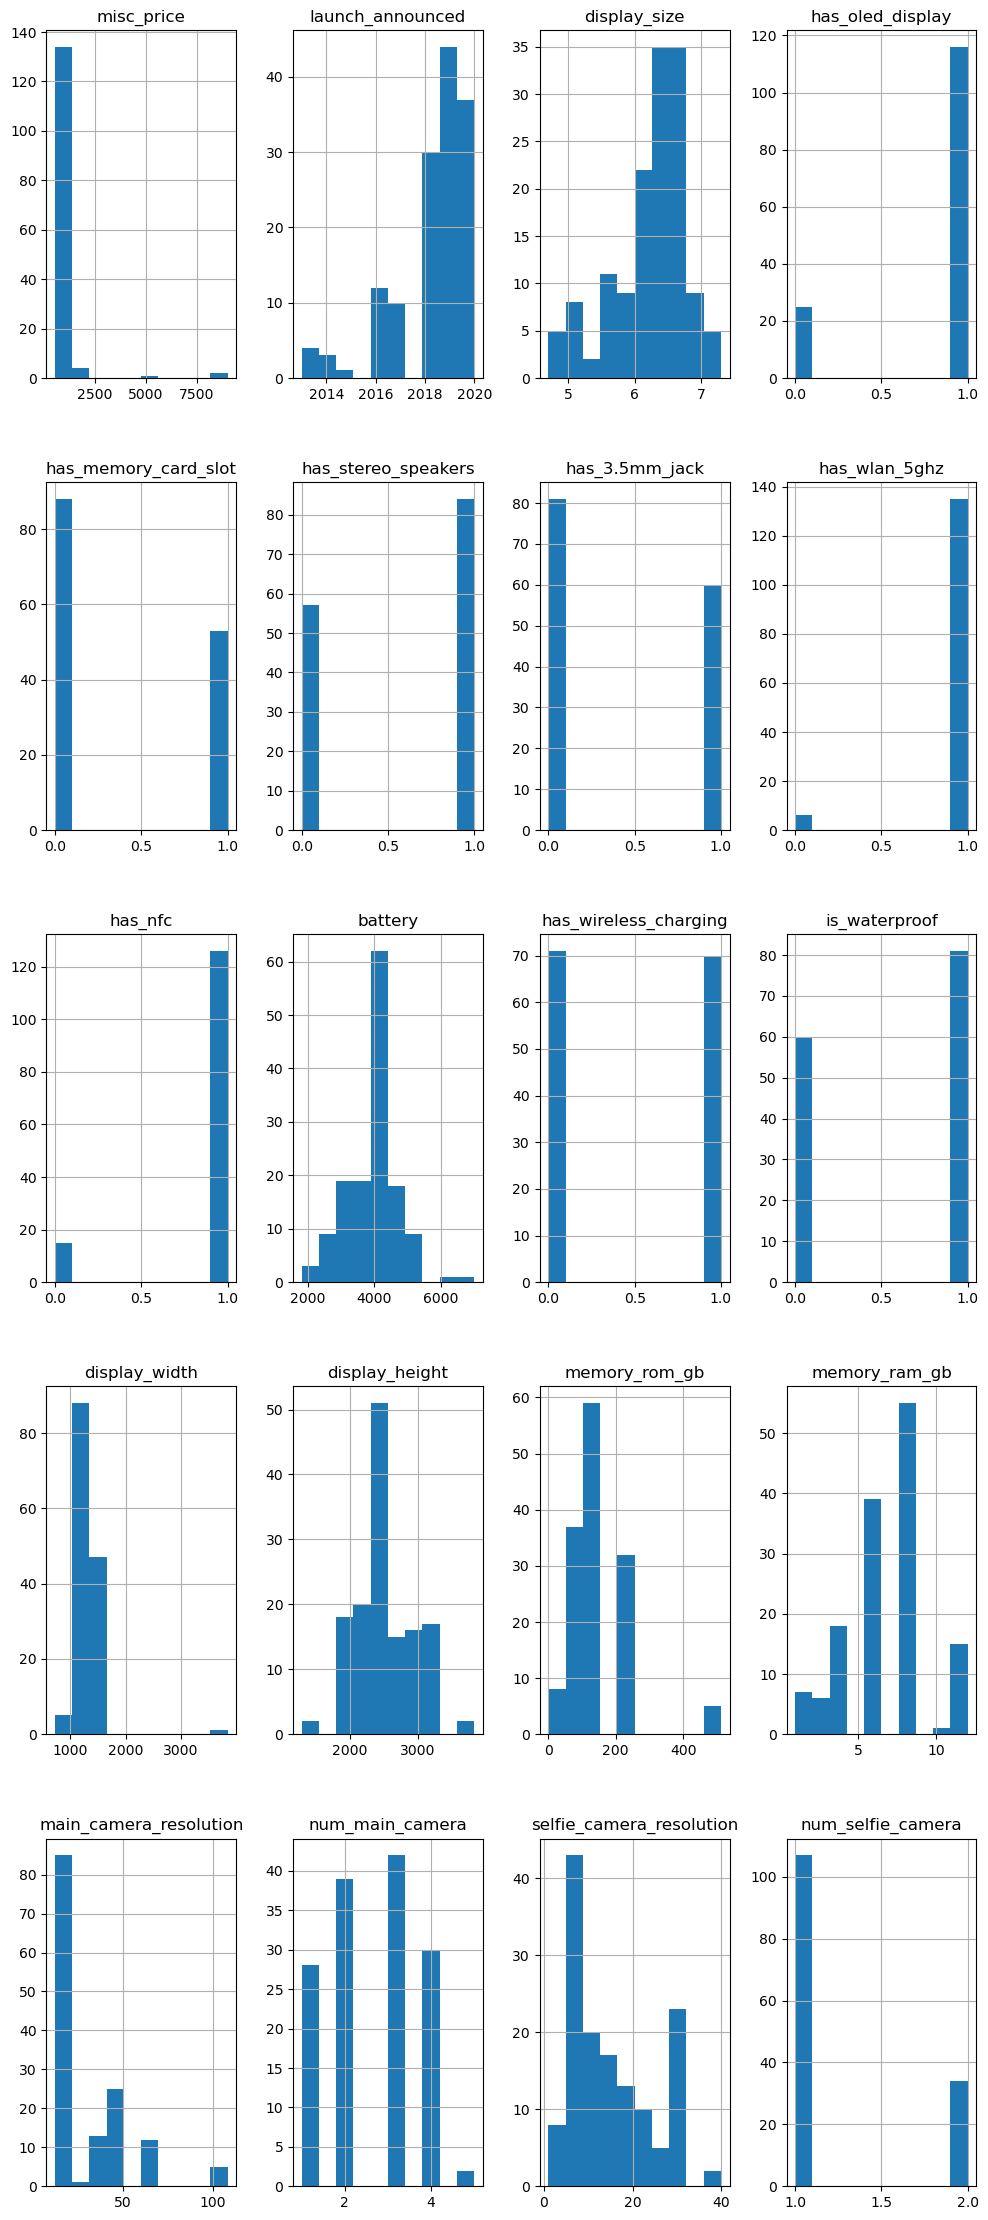

In [ ]:
from pandas.plotting import scatter_matrix

rows, cols = outliers.shape[1] // 3, 3
outliers.hist(bins=10, figsize=(cols * 4, rows * 4))
# outliers.hist(subplots=True, layout=(rows, cols), bins=50, figsize=(cols * 4, rows * 4), sharex=False)
plt.show()

Distribution of the price in different years.

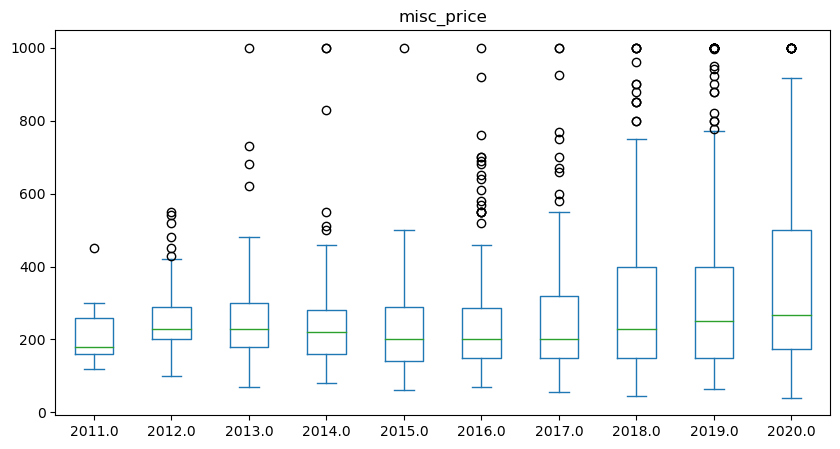

In [ ]:
# show boxplot of misc_price for distinct launch_announced
df_train.plot.box(by="launch_announced", column="misc_price", figsize=(10, 5))
plt.show()


#### Display size


<Axes: xlabel='display_width', ylabel='display_height'>

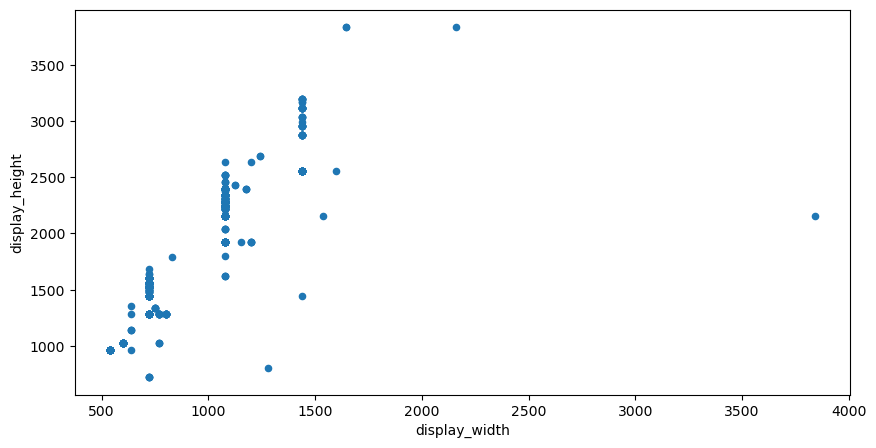

In [ ]:
df_train.plot(kind="scatter", x="display_width", y="display_height", figsize=(10, 5))

### Plot of numerical feature correlations


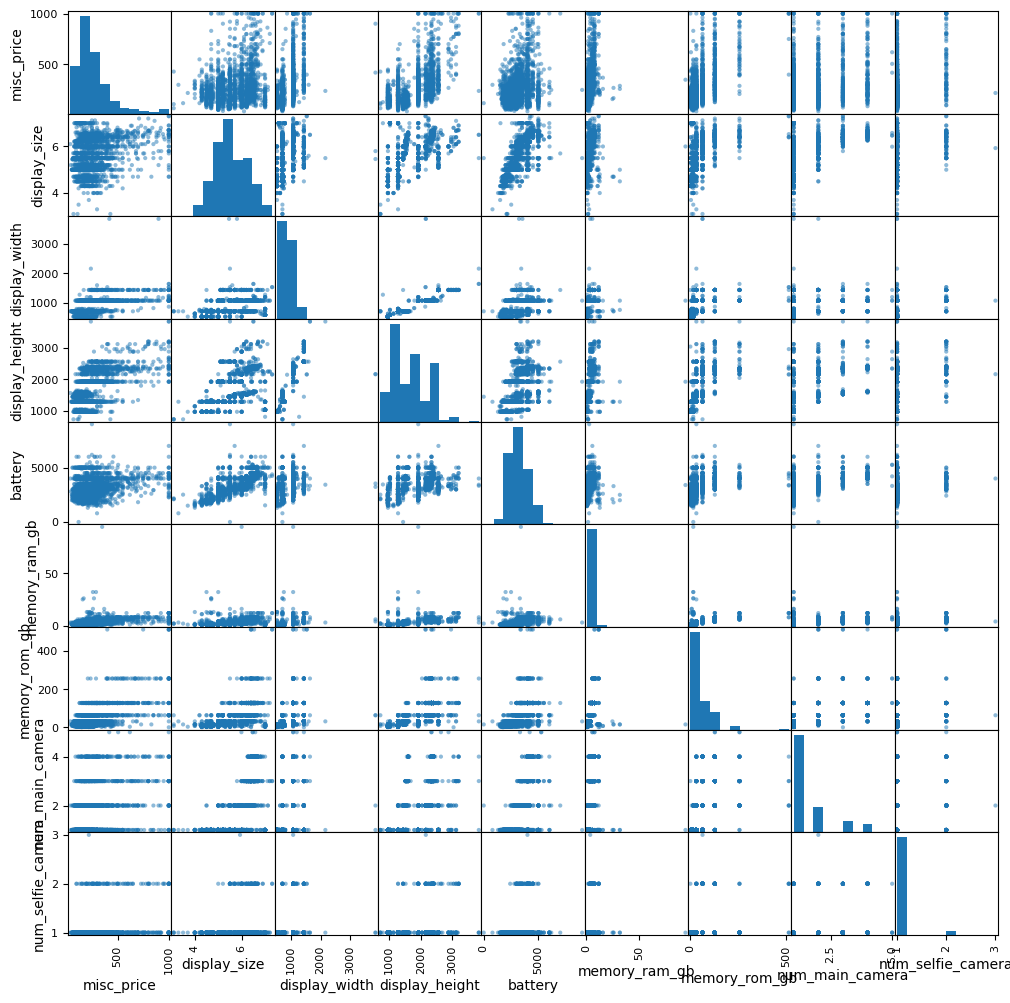

In [ ]:
from pandas.plotting import scatter_matrix


attributes = [
    "misc_price",
    "display_size",
    "display_width",
    "display_height",
    "battery",
    "memory_ram_gb",
    "memory_rom_gb",
    "main_camera_resolution",
    "num_main_camera",
    "selfie_camera_resolution",
    "num_selfie_camera",
]
scatter_matrix(df_train[attributes], figsize=(12, 12))
plt.show()


### Correlation between data


In [ ]:
df_train.corr(numeric_only=True)["misc_price"].sort_values(ascending=False)


misc_price               1.000000
memory_rom_gb            0.601073
display_height           0.595482
display_width            0.548772
has_oled_display         0.503945
has_wireless_charging    0.499889
has_wlan_5ghz            0.461080
has_nfc                  0.439080
memory_ram_gb            0.408230
is_waterproof            0.382199
has_stereo_speakers      0.381291
num_main_camera          0.360579
display_size             0.298718
num_selfie_camera        0.267992
battery                  0.262229
launch_announced         0.192252
has_memory_card_slot    -0.436761
has_3.5mm_jack          -0.525965
Name: misc_price, dtype: float64

Let's try to figure out if there are some correlations between the different features and we will try to perform an analysis to evaluate if it is worth to eventually delete some features.


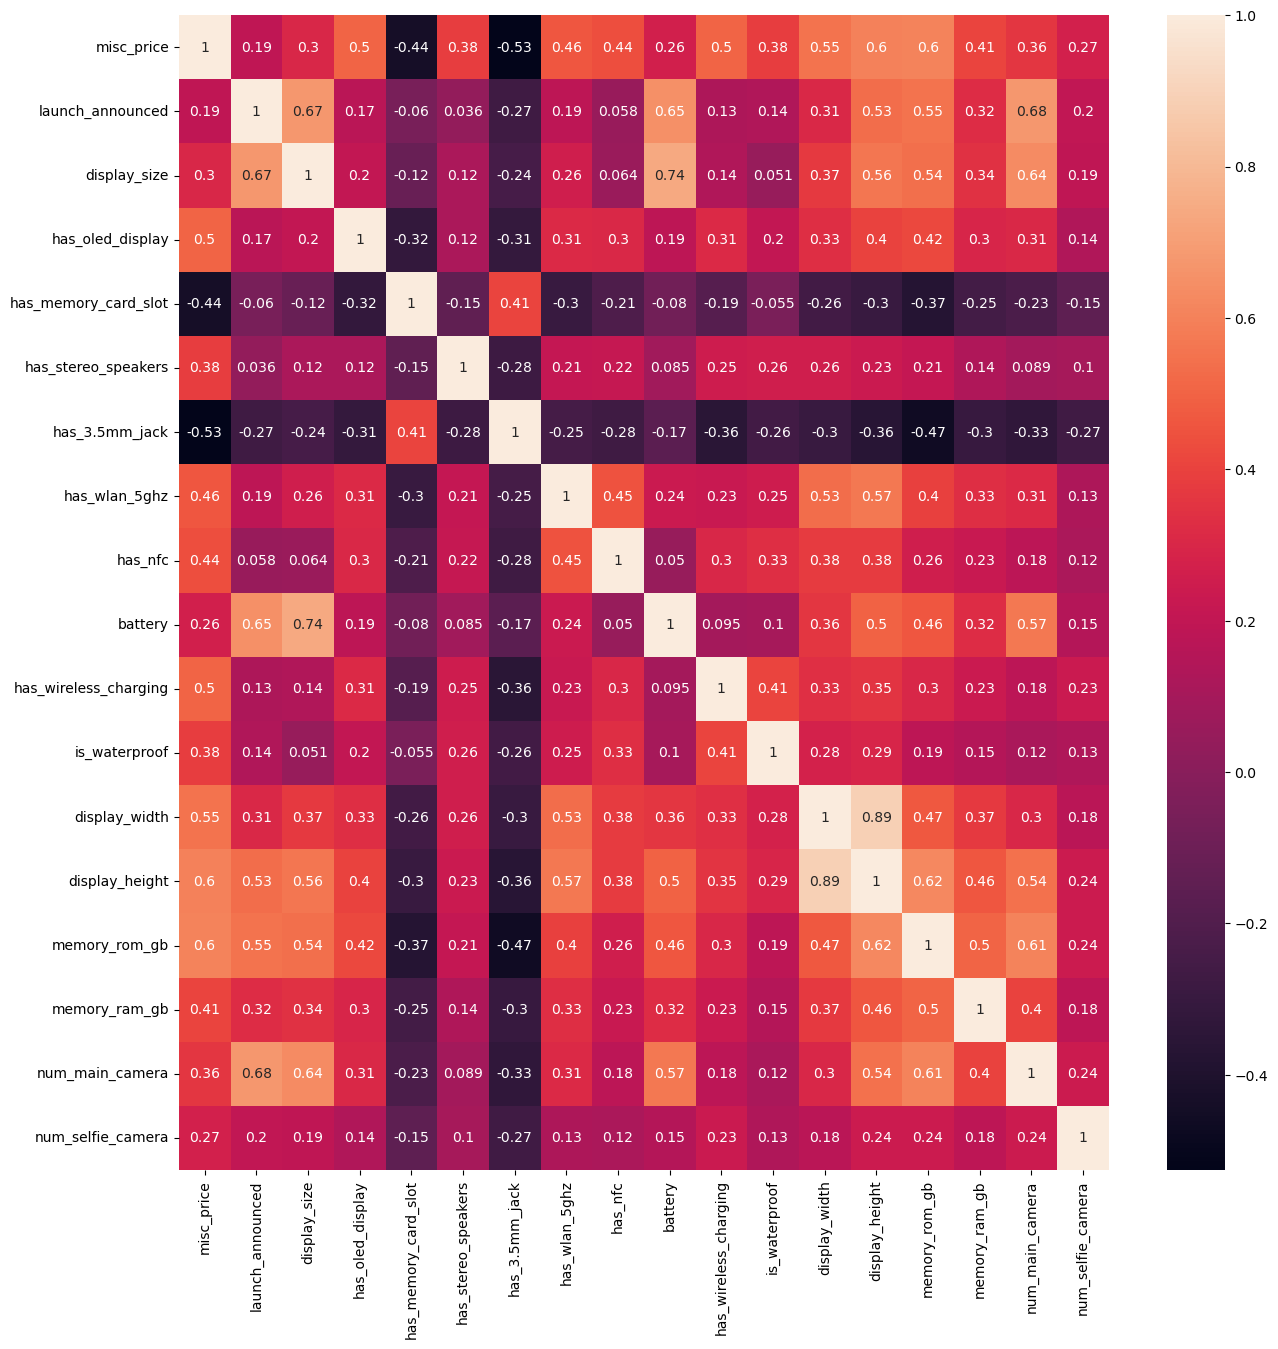

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_train.corr(numeric_only=True), annot=True)
plt.show()


In [ ]:
df_train.describe()


,misc_price,launch_announced,display_size,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,battery,has_wireless_charging,is_waterproof,display_width,display_height,memory_rom_gb,memory_ram_gb,main_camera_resolution,num_main_camera,selfie_camera_resolution,num_selfie_camera
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.00000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,271.292639,2016.342404,5.566310,0.242063,0.82483,0.149093,0.918934,0.545351,0.404195,3178.654762,0.065760,0.134921,907.308390,1721.971655,46.902494,3.338560,16.085544,1.524943,8.532880,1.045351
std,175.850707,2.304548,0.688973,0.428454,0.38022,0.356281,0.273013,0.498080,0.490875,872.761186,0.247932,0.341736,250.153135,522.944399,53.731603,2.623438,13.270005,0.882779,7.595579,0.210840
min,40.000000,2011.000000,3.100000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,540.000000,720.000000,1.000000,1.000000,2.000000,1.000000,0.300000,1.000000
25%,155.727500,2014.000000,5.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,2500.000000,0.000000,0.000000,720.000000,1280.000000,16.000000,2.000000,8.000000,1.000000,4.000000,1.000000
50%,220.000000,2016.000000,5.500000,0.000000,1.00000,0.000000,1.000000,1.000000,0.000000,3015.000000,0.000000,0.000000,768.000000,1585.000000,32.000000,3.000000,13.000000,1.000000,5.000000,1.000000
75%,320.000000,2018.000000,6.200000,0.000000,1.00000,0.000000,1.000000,1.000000,1.000000,4000.000000,0.000000,0.000000,1080.000000,2160.000000,64.000000,4.000000,16.000000,2.000000,12.000000,1.000000
max,1000.000000,2020.000000,7.300000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,9000.000000,1.000000,1.000000,3840.000000,3840.000000,512.000000,32.000000,108.000000,5.000000,44.000000,3.000000


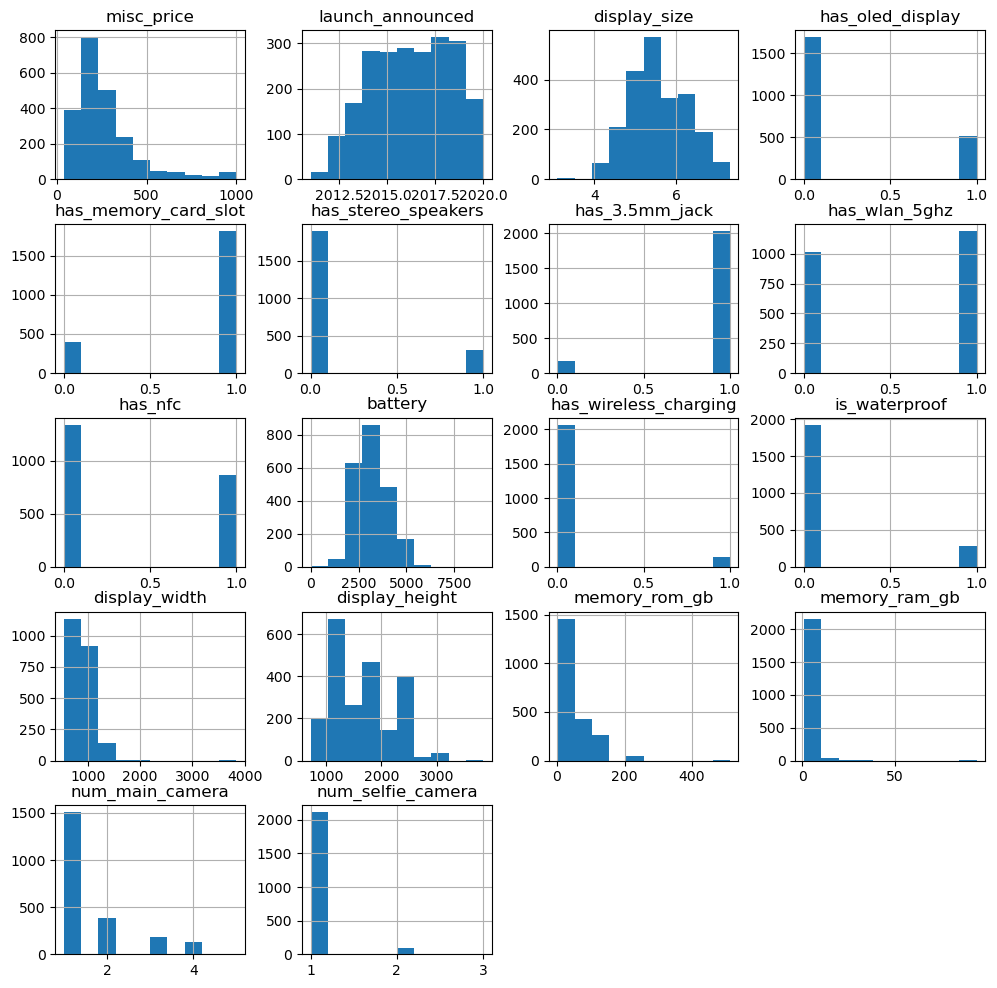

In [ ]:
df_train.hist(figsize=(12, 12))
plt.show()


## Transform features

In [ ]:
df_train = pd.read_csv("data/processed/gsm_train.csv")
df_test = pd.read_csv("data/processed/gsm_test.csv")

misc_price

In [ ]:
# set environment variable to avoid memory leak
# os.environ["OMP_NUM_THREADS"] = "7"

clip_fun = FunctionTransformer(np.clip, validate=False, check_inverse=False, feature_names_out="one-to-one", kw_args={"a_min": 100, "a_max": 600})
log_fun = FunctionTransformer(np.log, validate=False, check_inverse=True, inverse_func=np.exp, feature_names_out="one-to-one")
label_enc = KBinsDiscretizer(n_bins=4, encode="ordinal", subsample=None, strategy="uniform")

label_pipeline = make_pipeline(clip_fun, log_fun, label_enc)

display_size, battery, memory_ram_gb, memory_rom_gb, main_camera_resolution, selfie_camera_resolution

In [ ]:
num_columns = ["display_size", "battery", "memory_ram_gb", "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
num_pipeline = make_pipeline(
    FunctionTransformer(
        np.log1p, validate=False, check_inverse=True, inverse_func=np.expm1, feature_names_out="one-to-one"
    ),
    RobustScaler(with_centering=True, unit_variance=True)
)

display_width, display_height

In [ ]:
def display_transformer(df: pd.DataFrame, df_res: pd.DataFrame, ord=2) -> pd.DataFrame:
    def compute_distance(x, y):
        return np.argmin(np.linalg.norm(x - y, ord=ord, axis=1))

    series_transform = df.apply(lambda x: df_res.index[compute_distance(x, df_res)], axis=1)
    df_transform = pd.DataFrame(series_transform, columns=["display_resolution"])
    assert isinstance(df_transform, pd.DataFrame)
    return df_transform

resolutions = {"qHD": [540, 960], "HD": [720, 1280], "FHD": [1080, 1920], "QHD": [1440, 2560]}
df_res = pd.DataFrame.from_dict(resolutions, orient="index", columns=["display_width", "display_height"])

display_pipeline = make_pipeline(
    FunctionTransformer(display_transformer, kw_args={"df_res": df_res}, validate=False),
    OrdinalEncoder(categories=[list(resolutions.keys())])
)

network_technology, num_main_camera, num_selfie_camera

In [ ]:
ordinal_columns = ["network_technology", "num_main_camera", "num_selfie_camera"]
ordinal_categories = [["3G", "4G", "5G"], [1., 2., 3., 4., 5.], [1., 2., 3.]]
ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=ordinal_categories))

has_oled_display, has_memory_card_slot, has_stereo_speakers, has_3.5mm_jack, has_wlan_5ghz, has_nfc, has_wireless_charging, is_waterproof

In [ ]:
id_columns = ["has_oled_display", "has_memory_card_slot", "has_stereo_speakers", "has_3.5mm_jack", "has_wlan_5ghz", "has_nfc", "has_wireless_charging", "is_waterproof"]
id_pipeline = make_pipeline(FunctionTransformer(validate=False, feature_names_out="one-to-one"))

Pipeline for the transformation of the features.

In [ ]:
pipeline = make_column_transformer(
    [label_pipeline, ["misc_price"]],
    [num_pipeline, num_columns],
    [id_pipeline, id_columns],
    [ordinal_pipeline, ordinal_columns],
    [display_pipeline, ["display_width", "display_height"]],
    verbose_feature_names_out=False
)
pipeline.set_output(transform="pandas")
pipeline.fit(df_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('functiontransformer-1',
                                                  FunctionTransformer(check_inverse=False,
                                                                      feature_names_out='one-to-one',
                                                                      func=<function clip at 0x7f7bdcd5ca60>,
                                                                      kw_args={'a_max': 600,
                                                                               'a_min': 100})),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>,
                                                                      inverse_func=<ufunc 'exp'>)...
                                ('pipeline-5',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function display_transformer at 0x7f7ae8d7aa60>,
                                                                      kw_args={'df_res':      display_width  display_height
qHD            540             960
HD             720            1280
FHD           1080            1920
QHD           1440            2560})),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['qHD',
                                                                              'HD',
                                                                              'FHD',
                                                                              'QHD']]))]),
                                 ['display_width', 'display_height'])],
                  verbose_feature_names_out=False)

In [ ]:
bin_edges = np.exp(pipeline.transformers_[0][1][2].bin_edges_.item())
for i, (bu, bl) in enumerate(zip(bin_edges, bin_edges[1:])):
    print(f"Bin {i}: {bu:.2f} - {bl:.2f}")

Bin 0: 100.00 - 156.51
Bin 1: 156.51 - 244.95
Bin 2: 244.95 - 383.37
Bin 3: 383.37 - 600.00


In [ ]:
train_preprocess = pipeline.transform(df_train)
assert isinstance(train_preprocess, pd.DataFrame)
print(f"Number of rows before preprocessing: {train_preprocess.shape[0]}")

# keep only one instance between duplicates equal in all features
train_preprocess = train_preprocess.drop_duplicates(ignore_index=True, keep="first")
assert isinstance(train_preprocess, pd.DataFrame)

# remove all duplicated with different label
X_columns = train_preprocess.columns.drop("misc_price").to_list()
train_preprocess = train_preprocess.drop_duplicates(X_columns, keep=False, ignore_index=True)
assert isinstance(train_preprocess, pd.DataFrame)

print(f"Number of rows after preprocessing: {train_preprocess.shape[0]}")
train_preprocess.head()

Number of rows before preprocessing: 1759
Number of rows after preprocessing: 1757


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
0,1.0,0.000000,0.896591,-0.759706,0.000000,0.411819,0.572431,0,1,0,1,0,0,0,0,1.0,0.0,0.0,2.0
1,1.0,-0.349620,-0.270677,0.589274,0.681825,0.000000,1.196205,0,1,0,1,0,0,0,0,1.0,0.0,0.0,2.0
2,1.0,-0.592228,-0.762559,-1.830451,-1.306845,0.000000,0.000000,0,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0
3,1.0,0.548318,0.000000,0.000000,0.000000,0.000000,1.470312,0,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0
4,2.0,0.224226,-0.302390,-0.759706,-0.667155,0.000000,-0.978577,0,1,0,1,0,0,0,0,1.0,0.0,0.0,1.0


In [ ]:
util_data.count_frequency_labels(train_preprocess.misc_price).sort_index()

,Frequency,Count
0.0,24.59%,432
1.0,30.45%,535
2.0,28.00%,492
3.0,16.96%,298


Preprocess test set.

In [ ]:
test_preprocess = pipeline.transform(df_test)
assert isinstance(test_preprocess, pd.DataFrame)

print(f"Number of rows before preprocessing: {test_preprocess.shape[0]}")
# keep only one instance between duplicates equal in all features
test_preprocess = test_preprocess.drop_duplicates(ignore_index=True, keep="first")
assert isinstance(test_preprocess, pd.DataFrame)

# remove all duplicated with different label
X_columns = test_preprocess.columns.drop("misc_price").to_list()
test_preprocess = test_preprocess.drop_duplicates(X_columns, keep=False, ignore_index=True)
assert isinstance(test_preprocess, pd.DataFrame)

print(f"Number of rows after preprocessing: {test_preprocess.shape[0]}")
test_preprocess.head()

Number of rows before preprocessing: 440
Number of rows after preprocessing: 440


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof,network_technology,num_main_camera,num_selfie_camera,display_resolution
0,0.0,-0.592228,-0.762559,-0.759706,-0.667155,0.000000,0.000000,0,1,0,1,1,0,0,0,1.0,0.0,0.0,1.0
1,0.0,1.536304,0.896591,-0.759706,-0.667155,-1.797182,-0.978577,0,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0
2,0.0,-0.592228,-1.163638,-1.830451,-0.667155,-1.797182,-0.978577,0,1,0,1,0,0,0,0,0.0,0.0,0.0,1.0
3,2.0,1.058789,1.466230,1.477824,1.371239,3.256549,1.470312,0,1,0,1,1,0,0,1,1.0,3.0,0.0,2.0
4,3.0,0.000000,0.000000,-0.759706,0.000000,0.411819,1.470312,0,1,0,1,1,1,0,0,1.0,0.0,0.0,2.0


In [ ]:
# save train_preprocess
train_preprocess.to_csv("data/model/gsm_train.csv", index=False)
test_preprocess.to_csv("data/model/gsm_test.csv", index=False)